In [2]:
# pylint: disable=line-too-long
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit_nature.algorithms import (GroundStateEigensolver,
                                      NumPyMinimumEigensolverFactory)
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper
# pylint: enable=line-too-long

import matplotlib.pyplot as plt
import numpy as np
from qiskit_nature.circuit.library import UCCSD, HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP
from qiskit.opflow import TwoQubitReduction
from qiskit import BasicAer, Aer
from qiskit.utils import QuantumInstance
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit_ibm_provider import IBMProvider



/var/folders/85/nzm_vj2j78921yj8smfjsrx00000gn/T/ipykernel_30205/3338669671.py:3: NatureDeprecationWarning: The qiskit_nature.algorithms.excited_state_solvers package is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the qiskit_nature.second_q.algorithms.excited_state_solvers package.
  from qiskit_nature.algorithms import (GroundStateEigensolver,
/var/folders/85/nzm_vj2j78921yj8smfjsrx00000gn/T/ipykernel_30205/3338669671.py:3: NatureDeprecationWarning: The qiskit_nature.algorithms.pes_sampler package is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release . Please refer to 'https://github.com/Qiskit/qiskit-nature/issues/750' for additional information regarding 'extrapolators'.
  from qiskit_nature.algorithms import (GroundStateEigensolver,


In [3]:
def HEA_naive(num_q, depth):
    circuit = QuantumCircuit(num_q)
    params = ParameterVector("theta", length=num_q * (3 * depth + 2))
    counter = 0
    for q in range(num_q):
        circuit.rx(params[counter], q)
        counter += 1
        circuit.rz(params[counter], q)
        counter += 1
    for d in range(depth):
        for q in range(num_q - 1):
            circuit.cx(q, q + 1)
        for q in range(num_q):
            circuit.rz(params[counter], q)
            counter += 1
            circuit.rx(params[counter], q)
            counter += 1
            circuit.rz(params[counter], q)
            counter += 1
    return circuit, params


In [4]:
qubit_converter = QubitConverter(ParityMapper(), two_qubit_reduction=True)
numpy_solver = NumPyMinimumEigensolver()

In [5]:
def exact_solver(problem):
    calc = GroundStateEigensolver(qubit_converter, numpy_solver)
    result = calc.solve(problem)
    return result


In [6]:
def vqe_solver(problem, circuit):
    calc = GroundStateEigensolver(qubit_converter, circuit)
    result = calc.solve(problem)
    return result


In [8]:
backend = BasicAer.get_backend("statevector_simulator")
qi = QuantumInstance(backend)
distances1 = np.arange(0.5, 2.0, 0.2)
distances2 = np.arange(2.1, 4.0, 0.4)
distances = np.concatenate([distances1, distances2])
exact_energies = []
vqe_energies = []
vqe_energy_numbers = []
exact_energy_numbers = [] 

optimizer = SLSQP()
for dist in distances:
    molecule = Molecule(geometry=[
        ["H", [0.0, 0.0, dist]],
        ["Be", [0.0, 0.0, 0.0]],
        ["H", [0.0, 0.0, -dist]]
    ],
    multiplicity=1,  # = 2*spin + 1
    charge=0,
    )

    driver = ElectronicStructureMoleculeDriver(molecule=molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF)
    # Get properties
    properties = driver.run()
    num_particles = (properties.get_property("ParticleNumber").num_particles)
    num_spin_orbitals = int(properties.get_property("ParticleNumber").num_spin_orbitals)
    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = ElectronicStructureProblem(driver, [FreezeCoreTransformer(freeze_core=True, remove_orbitals=[4, 5])])
    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles
    
    exact_energies.append(exact_solver(problem))
    circuit = HEA_naive(6,3)[0]
    VQE_circuit = VQE(ansatz=circuit, quantum_instance=qi, optimizer=optimizer)
    vqe_energies.append(vqe_solver(problem, VQE_circuit))
    
    vqe_energy = str(vqe_energies[-1]).split(":")[5].split()[0]
    vqe_energy_numbers.append(float(vqe_energy))
    exact_energy = str(exact_energies[-1]).split(":")[5].split()[0]
    exact_energy_numbers.append(float(exact_energy))
    print(f"Length {dist} VQE Energy {vqe_energy} Exact Energy {exact_energy}")





Length 0.5 VQE Energy -13.660956072177 Exact Energy -13.661083921447
Length 0.7 VQE Energy -14.847348061869 Exact Energy -14.849662499682
Length 0.8999999999999999 VQE Energy -15.342496917479 Exact Energy -15.344848241984
Length 1.0999999999999999 VQE Energy -15.526408052503 Exact Energy -15.528475832701
Length 1.2999999999999998 VQE Energy -15.564426913815 Exact Energy -15.568625400665
Length 1.4999999999999998 VQE Energy -15.538040291632 Exact Energy -15.540966611742
Length 1.6999999999999997 VQE Energy -15.47590364596 Exact Energy -15.481291621499
Length 1.8999999999999997 VQE Energy -15.183995281946 Exact Energy -15.407692903669
Length 2.1 VQE Energy -15.373065120864 Exact Energy -15.412340363928
Length 2.5 VQE Energy -15.287031721607 Exact Energy -15.332919960557
Length 2.9 VQE Energy -15.201520266618 Exact Energy -15.307874432406
Length 3.3 VQE Energy -15.286166242626 Exact Energy -15.305817921747
Length 3.6999999999999997 VQE Energy -15.276974442384 Exact Energy -15.305905640248

In [7]:
hub = "ibm-q"#"qhack-event"
group = "open"#"main"
project = "main"#"project-1"
backend_name = "ibm_perth"
hgp = f"{hub}/{group}/{project}"

provider = IBMProvider()
backend = provider.get_backend(backend_name, instance=hgp)



qi = QuantumInstance(backend)
distances1 = np.arange(0.5, 2.0, 0.2)
distances2 = np.arange(2.1, 4.0, 0.4)
distances = np.concatenate([distances1, distances2])
exact_energies = []
vqe_energies = []
vqe_energy_numbers = []
exact_energy_numbers = []

optimizer = SLSQP(maxiter=5)
for dist in distances:
    molecule = Molecule(geometry=[
        ["H", [0.0, 0.0, dist]],
        ["Be", [0.0, 0.0, 0.0]],
        ["H", [0.0, 0.0, -dist]]
    ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF)
    # Get properties
    properties = driver.run()
    num_particles = (properties.get_property("ParticleNumber").num_particles)
    num_spin_orbitals = int(properties.get_property(
        "ParticleNumber").num_spin_orbitals)
    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = ElectronicStructureProblem(
        driver, [FreezeCoreTransformer(freeze_core=True, remove_orbitals=[4, 5])])
    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles
  
    exact_energies.append(exact_solver(problem))
    circuit = HEA_naive(6, 3)[0]
    VQE_circuit = VQE(ansatz=circuit, quantum_instance=qi, optimizer=optimizer)
    vqe_energies.append(vqe_solver(problem, VQE_circuit))

    vqe_energy = str(vqe_energies[-1]).split(":")[5].split()[0]
    vqe_energy_numbers.append(float(vqe_energy))
    exact_energy = str(exact_energies[-1]).split(":")[5].split()[0]
    exact_energy_numbers.append(float(exact_energy))
    print(f"Length {dist} VQE Energy {vqe_energy} Exact Energy {exact_energy}")


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'
/var/folders/85/nzm_vj2j78921yj8smfjsrx00000gn/T/ipykernel_30205/1790638132.py:2: NatureDeprecationWarning: The qiskit_nature.algorithms.ground_state_solvers.GroundStateEigensolver class is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the qiskit_nature.second_q.algorithms.ground_state_solvers.GroundStateEigensolver class.
  calc = GroundStateEigensolver(qubit_converter, numpy_solver)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/qiskit_ibm_provider/ibm_backend.py:431: UserWarning: The backend ibm_perth is currently paused.
  warnings.warn(f"The backend {self.name} is currently paused.")


KeyboardInterrupt: 

(-15.7, -12.0)

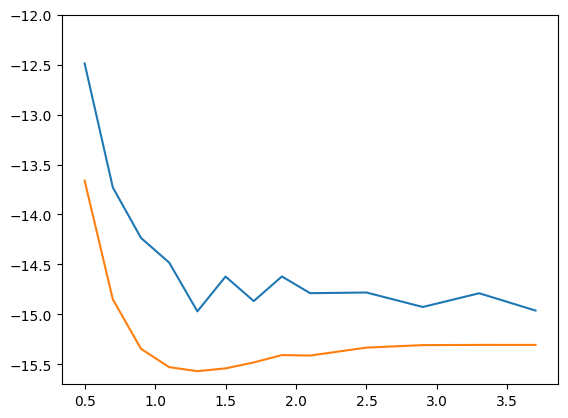

In [56]:
x = distances
y = vqe_energy_numbers
y2 = exact_energy_numbers
plt.plot(x, y)
plt.plot(x, y2)
plt.ylim(-15.7, -12)